# **DM - NN Course : Mini-Project**<br>Fiz Garrido Escudero             
# Phase 1: Ideation & Proposal

### 1.1 Theme Exploration & Problem Definition
- **Theme:** Traffic Sign Classification using Convolutional Neural Networks  
- **Specific Problem:** Misinterpretation or delayed recognition of traffic signs contributes to road accidents and compromises driver safety, especially for novice drivers or those unfamiliar with an area. Developing an automated recognition system can assist drivers and support advanced driver‑assistance systems (ADAS).  
- **Key Question:** How can we leverage convolutional neural networks to achieve high‑accuracy recognition of real‑world traffic signs under varying lighting, weather, and viewpoint conditions?

---

### 1.2 Dataset Search & Selection
- **Sources Explored:** Kaggle, UCI ML Repository, Open Data portals  
- **Candidate Datasets:**
  - **Traffic Sign Dataset Classification** (ahemateja19bec1025) – ~58 classes, includes “unknown” categories. Based on Chinese signs.  
  - **TT100K** & **Mapillary** – Very large and complex, require bounding‑box annotations.  
  - **GTSRB** – Standard benchmark, 43 classes, balanced, clear structure. Based on German signs.  

- **Selected Dataset:**
  - **Name:** GTSRB – German Traffic Sign Recognition Benchmark  
  - **Source:** Kaggle (`meowmeowmeowmeowmeow/gtsrb-german-traffic-sign`)  
  - **Total Images:** ≈ 52,000 (39,209 train + 12,630 test)  
  - **Classes:** 43 official categories  
  - **Format & Structure:**
    - `.png` images organized in folders `00000`, `00001`, ..., `00042`
    - Varied resolution (100×100 px – 1000×1000 px)  
  - **Rationale:**
    - Widely used benchmark → easy comparison  
    - Real-world variability (lighting, occlusion)  
    - Simple folder-per-class layout  
    - Contains German traffic signs that are similar to those used in Spain  

---

### 1.3 Proposal Formulation

| **Element**             | **Details**                                                                                                                                                                                                 |
|-------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Project Title**       | Convolutional Neural Network for German Traffic Sign Classification                                                                                                                                         |
| **Problem to Solve**    | Misinterpretation or delayed recognition of traffic signs contributes to road accidents and compromises driver safety, <br> especially for novice drivers or those unfamiliar with an area. <br>Developing an automated recognition system can assist drivers and support ADAS. |
| **Dataset Description** | **GTSRB – German Traffic Sign Recognition Benchmark** (_Kaggle_)  <br>– 43 classes  <br>– ≈ 52,000 images (.png)  <br>– Varied resolutions, real-world conditions  <br>– Folder structure: `Train/00000/`, ... |
| **Project Objectives**  | 1. **Data Pipeline:**  <br>   • Load images from disk  <br>   • Resize to 150 × 150 px + normalize RGB to [0,1]  <br>   • Apply data augmentation (rotations, zoom, shifts) to balance classes. <br><br><br>2. **Model Development:**  <br>   • Design CNN <br><br><br>3. **Training & Optimization:**  <br>   • Compile with `categorical_crossentropy` + Adam  <br>   • Train with early stopping & LR scheduling  <br>   • Tune hyperparameters (batch size, learning rate, filters)  <br><br><br>4. **Evaluation & Analysis:**  <br>   • Metrics: Accuracy, Confusion Matrix, etc. <br>   • Analyze misclassifications & propose improvements  <br><br><br>5. **Deliverables:**  <br>   • Present the Jupyter notebook as a evidence of the prcess   <br>   • Presentation slides with results, process & future work |

---



#Phase 2: Data Exploration & Preprocessing
##Imports

##IMPORTANT: I EXECUTED THE NOTEBOOK WITH GPU V100 AND MORE RAM FROM GOOGLE COLAB PRO. THE CODE DOESNT FINISH WITH THE FREE TRIAL RAM

In [1]:
import os
import time
import psutil
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, accuracy_score, f1_score, precision_score, recall_score,
    classification_report, roc_curve, auc
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, models

import kagglehub

from IPython.display import display

path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print("Dataset path:", path)




Dataset path: /kaggle/input/gtsrb-german-traffic-sign


##2.1. Initial Loading & Exploration

Below is a description of the **DATASET ORGANIZATION** and how the labels were obtained:

The Train/ directory contains 43 subfolders numbered from 0 to 42. Each subfolder groups all images belonging to a single class, so the folder name itself serves as the label. This structure allows labels to be extracted without any auxiliary files: it is enough to iterate through the folders, load each image, resize it, and normalize its RGB values.

Although the dataset also provides a Test/ directory (with all images in one level) and a corresponding Test.csv (columns Filename and ClassId) , I did not use either the Test/ folder or the test CSV. **All subsequent processing was carried out exclusively with the images in Train/.**

During this process **NO MISSING VALLUES WERE DETECTED**: every file was a valid image and had a recoverable label via its folder name. Consequently, no imputation was required; the pipeline was limited to loading → resizing → normalizing → building the data and label arrays.

In [2]:
df = pd.read_csv(os.path.join(path, "Train.csv"), sep = "," )

# 1. Check standard missing values (NaN)
print(df.isnull().sum())             # Number of NaN per column
print("Any NaN present?:", df.isnull().any().any())

# 2. Check also for empty strings "" (which are not NaN by default)
empty_strings = df.astype(str).applymap(lambda x: x.strip() == "").sum()
print("Empty string cells per column:")
print(empty_strings)
print("\n\nNO MISSING VALUES WERE DETECTED")


Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64
Any NaN present?: False
Empty string cells per column:
Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64


NO MISSING VALUES WERE DETECTED


/tmp/ipython-input-2-2663196536.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  empty_strings = df.astype(str).applymap(lambda x: x.strip() == "").sum()


##2.2 Data cleaning

I did not perform a dedicated Data Cleaning phase because:

**No nulls**: every image exists and has a label (by folder name in Train).

**No relevant duplicates**: the benchmark is already curated; no repeated files were found when loading.

**Homogeneous format**: all samples are valid .png images; none were corrupted.

**No obvious outliers**: as an official dataset, there are no non–traffic‑sign images; minor visual variations are handled by resizing and normalization.

Therefore, preprocessing was limited to loading, resizing, and normalizing images, without needing imputation or additional cleaning steps.

##2.3. Feature Transformation & Preparation (Feature Engineering)



The chosen dataset is not provided in DataFrame format, so **I manually processed each image of the Train folder**.

I **RESIZED** all images to a fixed size and converted them into pixel arrays. Each pixel contains 3 values corresponding to the RGB channels. I then associated each image array with its corresponding traffic sign class label (index). I also **NORMALIZE** the RGB values of each image by scaling them to the [0, 1] range. This is done by dividing each pixel value by 255, which helps the model train more efficiently. Normalization improves the convergence speed and stability of the neural network, as it ensures that all input features (in this case, the pixel intensities) are on a similar scale. This step is essential in image-based deep learning tasks and contributes to better learning performance.



In [3]:


# Step 1: Set up variables
data = []
labels = []
num_classes = 43

# Step 2: Loop over each class folder for training data
training_path = os.path.join(path, "Train")

for class_index in tqdm(range(num_classes), desc="Loading training images"):
    class_path = os.path.join(training_path, str(class_index))
    if not os.path.isdir(class_path):
        continue
    for filename in os.listdir(class_path):
        if filename.endswith(".png"):
            try:
                img_path = os.path.join(class_path, filename)
                image = Image.open(img_path).resize((150, 150))

                image = np.array(image) / 255.0  # RGB Normalization

                data.append(image)
                labels.append(class_index)
            except Exception as e:
                print(f"Error loading image {filename}: {e}")

# Step 3: Convert lists to NumPy arrays
data = np.array(data)
labels = np.array(labels)

print("Full Train folder shape:", data.shape, labels.shape)

Loading training images: 100%|██████████| 43/43 [01:08<00:00,  1.59s/it]


Full Train folder shape: (39209, 150, 150, 3) (39209,)


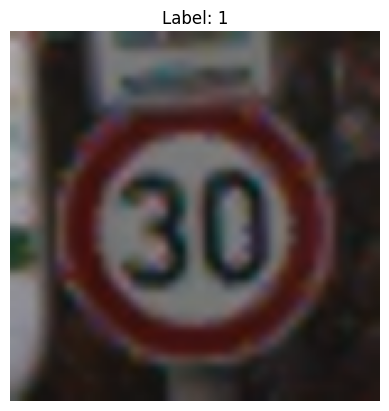

In [4]:
img_uint8 = (data[250] * 255).astype('uint8')
plt.imshow(img_uint8)
plt.title(f"Label: {labels[250]}")
plt.axis('off')
plt.show()

##2.6 Class Balancing (Subsampling & Oversampling) implementation

To ensure a balanced training set across all 43 traffic sign classes, a mixed strategy combining subsampling and oversampling was applied. The target was to obtain exactly 500 samples per class, regardless of their original frequency.

The dataset exhibits class imbalance: some classes contain thousands of samples while others have only a few hundred. To address this, the following logic was implemented:

Subsampling was applied to overrepresented classes: 500 samples were randomly selected without replacement.

Oversampling was applied to underrepresented classes: existing samples were randomly duplicated with replacement until reaching 500.

This process was performed before the train/validation/test split, ensuring all subsets derive from a balanced pool. As a result, the model is trained on uniformly distributed classes, which helps prevent bias toward majority classes and improves generalization.

In [5]:
# 1) Total memory footprint in RAM
bytes_total = data.nbytes + labels.nbytes
mb_total = bytes_total / (1024**2)
print(f"Total RAM used by X+y: {mb_total:.2f} MB")

# 2) Class count to inspect imbalance
cls_counts = Counter(labels.tolist())
cls_df = pd.DataFrame.from_dict(cls_counts, orient='index', columns=['count']).sort_index()
print("\nSamples per class:\n", cls_df.head(), "...\n")
print("Min per class:", cls_df['count'].min(), " Max per class:", cls_df['count'].max())

# 3) Very rough epoch time estimate:
#    We run a single training step on a small batch and extrapolate.
#    (Only for justification, not for exact timing.)
model = models.Sequential([
    layers.Input(shape=data.shape[1:]),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(43, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

batch_size = 64
sample_batch = data[:batch_size]
sample_labels = labels[:batch_size]

start = time.time()
model.train_on_batch(sample_batch, sample_labels)
elapsed = time.time() - start
iters_per_epoch = len(data) // batch_size
epoch_est = elapsed * iters_per_epoch
print(f"\nEstimated time per epoch with full data: ~{epoch_est/60:.1f} minutes")

# 4) Automatic conclusions / warnings
RAM_LIMIT_MB = 83000  # ~83 GB Colab GPU RAM (approx), tweak if needed
if mb_total > RAM_LIMIT_MB / 2:
    print("\n>>> WARNING: Dataset uses a large portion of RAM. Subsampling is recommended.")
if cls_df['count'].min() * 5 < cls_df['count'].max():  # crude imbalance rule
    print(">>> WARNING: Strong class imbalance detected. Consider stratified subsampling or class weights.")
if epoch_est > 10 * 60:
    print(">>> WARNING: Estimated epoch time > 10 minutes. Subsampling can speed up experimentation.")


Total RAM used by X+y: 20192.31 MB

Samples per class:
    count
0    210
1   2220
2   2250
3   1410
4   1980 ...

Min per class: 210  Max per class: 2250

Estimated time per epoch with full data: ~46.2 minutes
>>> WARNING: Strong class imbalance detected. Consider stratified subsampling or class weights.
>>> WARNING: Estimated epoch time > 10 minutes. Subsampling can speed up experimentation.


In [6]:
# We proceed to do oversampling for poor classes and subsampling for big classes

def balanced_subsample_or_oversample(X, y, target_per_class=500, random_state=42):
    np.random.seed(random_state)
    class_indices = defaultdict(list)

    for idx, label in enumerate(y):
        class_indices[label].append(idx)

    X_balanced = []
    y_balanced = []

    for label, indices in class_indices.items():
        indices = np.array(indices)
        n = len(indices)

        if n >= target_per_class:
            chosen = np.random.choice(indices, size=target_per_class, replace=False)
        else:
            chosen = np.random.choice(indices, size=target_per_class, replace=True)

        X_balanced.append(X[chosen])
        y_balanced.append(np.full(target_per_class, label))

    X_balanced = np.concatenate(X_balanced, axis=0)
    y_balanced = np.concatenate(y_balanced, axis=0)

    # Shuffle final
    shuffle_idx = np.random.permutation(len(X_balanced))
    return X_balanced[shuffle_idx], y_balanced[shuffle_idx]

balanced_data, balanced_labels = balanced_subsample_or_oversample(data, labels, target_per_class=350)

##2.4. Dataset Splitting
I chose to extract all subsets (training, validation, and test) exclusively from the Train/ directory to maintain full control over the data distribution and size.

A stratified split was applied to ensure class balance across the three sets. First, 15% of the data was separated as a test set. Then, from the remaining 85%, another split was performed to carve out a validation set (15% of the original total). This resulted in final proportions of 70% training, 15% validation, and 15% test, all derived from the original training folder.

This approach ensured consistent preprocessing and avoided relying on external CSVs or additional metadata.

In [7]:


# Split Train folder into Train (70%), Val (15%), Test (15%)

# 1) Take 15% for test
tmp_data, test_data, tmp_labels, test_labels = train_test_split(
    balanced_data, balanced_labels,
    test_size=0.15, stratify=balanced_labels, random_state=42
)

# 2) From the remainival_data%, take 15% of the total for validation
#    15 / (70 + 15) = 0.176470... of the remaining tmp_data
training_data, val_data, training_labels, val_labels = train_test_split(
    tmp_data, tmp_labels,
    test_size=15 / (70 + 15), stratify=tmp_labels, random_state=42
)

print("Train:", training_data.shape, training_labels.shape)
print("Val  :", val_data.shape,   val_labels.shape)
print("Test :", test_data.shape,  test_labels.shape)
print(val_labels)

Train: (10534, 150, 150, 3) (10534,)
Val  : (2258, 150, 150, 3) (2258,)
Test : (2258, 150, 150, 3) (2258,)
[36 30 41 ... 38 10 42]


##2.5 Labels mapping

I manually created a dictionary that maps class indices to their corresponding traffic signs, since the dataset does not include this information, in case you would like to test the model with new data.

In [8]:
# Dictionary mapping GTSRB class indices (filename numbers) to English sign names
label_map = {
    0:  "Speed limit (20 km/h)",
    1:  "Speed limit (30 km/h)",
    2:  "Speed limit (50 km/h)",
    3:  "Speed limit (60 km/h)",
    4:  "Speed limit (70 km/h)",
    5:  "Speed limit (80 km/h)",
    6:  "End of speed limit (80 km/h)",
    7:  "Speed limit (100 km/h)",
    8:  "Speed limit (120 km/h)",
    9:  "No passing",
    10: "No passing for vehicles over 3.5 t",
    11: "Right‑of‑way at next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 t prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve to the left",
    20: "Dangerous curve to the right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed & passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 t"
}


#Phase 3: Neural Network Design & Training
##3.1. Neural Network Architecture Selection
To tackle the traffic sign classification problem, we selected a neural architecture based on MobileNetV2, a lightweight and efficient convolutional **model pre-trained on ImageNet**. This choice was motivated by several advantages:

**Computational efficiency:** MobileNetV2 is optimized for devices with limited resources, allowing for fast training and low memory usage—ideal for environments like Google Colab.

**Transfer learning:** By using a pre-trained model, we leveraged general visual features already learned (such as shapes, edges, and patterns), improving performance even with a limited dataset.

**Good generalization:** MobileNetV2 has demonstrated strong performance across various image classification tasks, making it a robust baseline.

We froze the base model’s weights to retain learned features and added custom layers on top to adapt it specifically to our 43-class classification problem.

##3.2. Model Construction
On top of MobileNetV2, we added a custom classification head with the following layers:

**GlobalAveragePooling2D**: Converts feature maps into a single vector by averaging spatial dimensions, reducing the number of parameters and computational load.

**Batch Normalization:** Stabilizes training and accelerates convergence by normalizing intermediate outputs.

**Dense Layer:** Introduces a fully connected layer with ReLU activation to capture complex feature combinations.

**Dropout Layer:** Applies regularization by randomly deactivating neurons during training, helping prevent overfitting.

**Output Layer:** A softmax layer with 43 output neurons (one per class) provides class probabilities for multiclass classification.

This structure offers a good balance between performance and model complexity, enabling efficient learning while minimizing the risk of overfitting.

##3.3. Compilation & Training
The model was compiled using the **Adam optimizer**, known for its adaptive learning rates and efficiency in practice. We experimented with multiple learning rates to fine-tune the convergence.

The chosen loss function was sparse categorical crossentropy, which is suitable for multiclass problems with integer-encoded labels (rather than one-hot vectors), making it more memory-efficient.

Key training strategies included:

**Batch training:** Training in mini-batches instead of full dataset improves memory usage and stability.

**Early Stopping:** Automatically stops training when the validation accuracy no longer improves, saving time and avoiding overfitting.

**Validation split:** Part of the training data was reserved for validation, allowing real-time monitoring of the model's generalization during training.

The model was trained across different hyperparameter configurations and evaluated on a separate test set to ensure fair performance measurement.

##3.4. Hyperparameter Tuning
We performed a grid search over a defined set of hyperparameters:

**Learning rate:** Controls how much the weights are updated after each step.

**Dropout rate:** Adjusts the strength of regularization to prevent overfitting.

**Dense layer units:** Determines model capacity to learn complex representations.

**Batch size**: Balances between memory usage and stability of gradients.

**Number of epochs:** Dictates how long the model is trained.

Each configuration was trained, validated, and tested. For each run, we recorded key performance metrics such as:

Test loss and accuracy

F1-score (macro and weighted)

Precision and recall (macro)

The training history, model predictions, and true labels were stored for each configuration to allow further visualization and analysis. This tuning process helped us identify the best-performing configuration, which was later used for in-depth evaluation and plotting (e.g. confusion matrix, learning curves, and more).

In [9]:
# Hyperparameters to explore
learning_rates = [1e-3, 1e-4]
dropout_rates = [0.4]
dense_units    = [256]
batch_sizes    = [32, 64]
epochs_list    = [10, 30]

# Dataset details
num_classes = 43
input_shape = (150, 150, 3)

# To store results and histories
results = []
saved_histories = []
saved_preds = []
saved_true = []
saved_names = []

# Grid search over all combinations of hyperparameters
for lr in learning_rates:
    for dr in dropout_rates:
        for units in dense_units:
            for bs in batch_sizes:
                for ep in epochs_list:
                    config_name = f"lr={lr}_do={dr}_units={units}_bs={bs}_ep={ep}"
                    print(f"\n===== Training {config_name} =====")

                    # Load MobileNetV2 as feature extractor (no top classification layer)
                    base_model = tf.keras.applications.MobileNetV2(
                        input_shape=input_shape,
                        include_top=False,
                        weights='imagenet'
                    )
                    base_model.trainable = False  # Freeze base model weights

                    # Build the classification model on top of MobileNetV2
                    model = models.Sequential([
                        base_model,
                        layers.GlobalAveragePooling2D(),
                        layers.BatchNormalization(),
                        layers.Dense(units, activation='relu'),
                        layers.Dropout(dr),
                        layers.Dense(num_classes, activation='softmax')
                    ])

                    # Compile the model
                    model.compile(
                        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy']
                    )

                    # Early stopping to prevent overfitting
                    early_stop = tf.keras.callbacks.EarlyStopping(
                        monitor='val_accuracy',
                        patience=3,
                        restore_best_weights=True
                    )

                    # Train the model
                    history = model.fit(
                        training_data, training_labels,
                        validation_data=(val_data, val_labels),
                        epochs=ep,
                        batch_size=bs,
                        verbose=1,
                        callbacks=[early_stop]
                    )

                    # Get predictions on test set
                    test_probs = model.predict(test_data, batch_size=bs, verbose=0)
                    test_preds = np.argmax(test_probs, axis=1)

                    # Evaluate test performance
                    test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)

                    # Compute additional metrics
                    f1_macro    = f1_score(test_labels, test_preds, average='macro')
                    f1_weighted = f1_score(test_labels, test_preds, average='weighted')
                    precision_macro = precision_score(test_labels, test_preds, average='macro')
                    recall_macro    = recall_score(test_labels, test_preds, average='macro')

                    # Save metrics for this configuration
                    results.append({
                        'config': config_name,
                        'learning_rate': lr,
                        'dropout': dr,
                        'dense_units': units,
                        'batch_size': bs,
                        'epochs': ep,
                        'val_accuracy': history.history['val_accuracy'][-1],
                        'test_accuracy': test_accuracy,
                        'test_loss': test_loss,
                        'f1_macro': f1_macro,
                        'f1_weighted': f1_weighted,
                        'precision_macro': precision_macro,
                        'recall_macro': recall_macro
                    })

                    # Store predictions, ground truths, and training history
                    saved_histories.append(history.history)
                    saved_preds.append((test_preds, test_probs))
                    saved_true.append(test_labels.copy())
                    saved_names.append(config_name)



===== Training lr=0.001_do=0.4_units=256_bs=32_ep=10 =====


/tmp/ipython-input-9-3892780855.py:29: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.4639 - loss: 2.0837 - val_accuracy: 0.8534 - val_loss: 0.4774
Epoch 2/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8308 - loss: 0.5398 - val_accuracy: 0.9004 - val_loss: 0.3209
Epoch 3/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8787 - loss: 0.3648 - val_accuracy: 0.9101 - val_loss: 0.2843
Epoch 4/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9071 - loss: 0.2769 - val_accuracy: 0.9216 - val_loss: 0.2544
Epoch 5/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9255 - loss: 0.2228 - val_accuracy: 0.9203 - val_loss: 0.2300
Epoch 6/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9308 - loss: 0.1948 - val_accuracy: 0.9322 - val_loss: 0.2292
Epoch 7/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9471 - loss: 0.1576 - val_accuracy: 0.9296 - val_loss: 0.2278
Epoch 8/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9403 - loss: 0.1773 - val_accurac

/tmp/ipython-input-9-3892780855.py:29: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.4778 - loss: 2.0240 - val_accuracy: 0.8680 - val_loss: 0.4661
Epoch 2/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8303 - loss: 0.5322 - val_accuracy: 0.8902 - val_loss: 0.3296
Epoch 3/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8789 - loss: 0.3719 - val_accuracy: 0.9119 - val_loss: 0.2746
Epoch 4/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9098 - loss: 0.2761 - val_accuracy: 0.9194 - val_loss: 0.2615
Epoch 5/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9256 - loss: 0.2235 - val_accuracy: 0.9256 - val_loss: 0.2496
Epoch 6/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9349 - loss: 0.1903 - val_accuracy: 0.9322 - val_loss: 0.2316
Epoch 7/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9375 - loss: 0.1709 - val_accuracy: 0.9194 - val_loss: 0.2457
Epoch 8/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9488 - loss: 0.1511 - val_acc

/tmp/ipython-input-9-3892780855.py:29: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.4243 - loss: 2.2341 - val_accuracy: 0.8361 - val_loss: 0.6017
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8253 - loss: 0.5559 - val_accuracy: 0.8990 - val_loss: 0.3429
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8959 - loss: 0.3318 - val_accuracy: 0.9229 - val_loss: 0.2703
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9205 - loss: 0.2487 - val_accuracy: 0.9247 - val_loss: 0.2500
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9422 - loss: 0.1834 - val_accuracy: 0.9296 - val_loss: 0.2240
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9510 - loss: 0.1523 - val_accuracy: 0.9371 - val_loss: 0.1994
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9589 - loss: 0.1205 - val_accuracy: 0.9283 - val_loss: 0.2163
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9672 - loss: 0.1060 - val_ac

/tmp/ipython-input-9-3892780855.py:29: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.4387 - loss: 2.1771 - val_accuracy: 0.8335 - val_loss: 0.6221
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8329 - loss: 0.5328 - val_accuracy: 0.8946 - val_loss: 0.3551
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8959 - loss: 0.3250 - val_accuracy: 0.9229 - val_loss: 0.2734
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9235 - loss: 0.2364 - val_accuracy: 0.9287 - val_loss: 0.2411
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9502 - loss: 0.1673 - val_accuracy: 0.9309 - val_loss: 0.2172
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9524 - loss: 0.1434 - val_accuracy: 0.9278 - val_loss: 0.2214
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9570 - loss: 0.1300 - val_accuracy: 0.9336 - val_loss: 0.1995
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9642 - loss: 0.1100 - val_acc

/tmp/ipython-input-9-3892780855.py:29: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.1431 - loss: 3.5867 - val_accuracy: 0.6249 - val_loss: 1.5068
Epoch 2/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5316 - loss: 1.6172 - val_accuracy: 0.7586 - val_loss: 0.9666
Epoch 3/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6601 - loss: 1.1525 - val_accuracy: 0.8149 - val_loss: 0.7432
Epoch 4/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7265 - loss: 0.9080 - val_accuracy: 0.8423 - val_loss: 0.6113
Epoch 5/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7804 - loss: 0.7508 - val_accuracy: 0.8720 - val_loss: 0.5255
Epoch 6/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8156 - loss: 0.6377 - val_accuracy: 0.8880 - val_loss: 0.4626
Epoch 7/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8486 - loss: 0.5440 - val_accuracy: 0.8964 - val_loss: 0.4196
Epoch 8/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8600 - loss: 0.4811 - val_acc

/tmp/ipython-input-9-3892780855.py:29: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.1424 - loss: 3.5784 - val_accuracy: 0.6103 - val_loss: 1.4964
Epoch 2/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5319 - loss: 1.6223 - val_accuracy: 0.7484 - val_loss: 0.9690
Epoch 3/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6609 - loss: 1.1750 - val_accuracy: 0.8020 - val_loss: 0.7460
Epoch 4/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7445 - loss: 0.8918 - val_accuracy: 0.8463 - val_loss: 0.6117
Epoch 5/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7805 - loss: 0.7474 - val_accuracy: 0.8667 - val_loss: 0.5222
Epoch 6/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8138 - loss: 0.6414 - val_accuracy: 0.8764 - val_loss: 0.4652
Epoch 7/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8416 - loss: 0.5409 - val_accuracy: 0.8897 - val_loss: 0.4159
Epoch 8/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8638 - loss: 0.4668 - val_acc

/tmp/ipython-input-9-3892780855.py:29: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.1029 - loss: 3.8710 - val_accuracy: 0.5244 - val_loss: 1.9742
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4553 - loss: 1.9408 - val_accuracy: 0.6798 - val_loss: 1.2564
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5858 - loss: 1.4196 - val_accuracy: 0.7578 - val_loss: 0.9532
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6711 - loss: 1.1154 - val_accuracy: 0.8091 - val_loss: 0.7799
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7331 - loss: 0.9217 - val_accuracy: 0.8299 - val_loss: 0.6688
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7702 - loss: 0.7889 - val_accuracy: 0.8547 - val_loss: 0.5905
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8135 - loss: 0.6512 - val_accuracy: 0.8676 - val_loss: 0.5330
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8240 - loss: 0.6057 - val_acc

/tmp/ipython-input-9-3892780855.py:29: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.0979 - loss: 3.9840 - val_accuracy: 0.5137 - val_loss: 1.9631
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4387 - loss: 1.9741 - val_accuracy: 0.6904 - val_loss: 1.2498
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5934 - loss: 1.4029 - val_accuracy: 0.7653 - val_loss: 0.9431
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6700 - loss: 1.1428 - val_accuracy: 0.8034 - val_loss: 0.7730
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7270 - loss: 0.9191 - val_accuracy: 0.8286 - val_loss: 0.6631
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7741 - loss: 0.7875 - val_accuracy: 0.8503 - val_loss: 0.5876
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8024 - loss: 0.6950 - val_accuracy: 0.8623 - val_loss: 0.5265
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8282 - loss: 0.6087 - val_acc

###OJO --> Los entrenamientos configurados con 30 epochs suelen detenerse antes por la inplementacíon de earlyStopping

#Phase 4: Evaluation, Analysis & Conclusions
##4.1. Model Evaluation:
To compare the performance of all trained configurations, we created a summary table sorted by validation accuracy (val_accuracy). This table also includes test accuracy, test loss, and several additional performance metrics: f1_macro, f1_weighted, precision_macro, and recall_macro, all rounded to 4 decimal places for clarity. A blue gradient highlights the best-performing values in each metric, improving readability.

Among all configurations tested, the best model was:

Config: lr=0.0001_do=0.4_units=256_bs=64_ep=30

Validation Accuracy: 0.9424

Test Accuracy: 0.9393

Test Loss: 0.2090

F1 macro: 0.9385

Precision macro: 0.9395

Recall macro: 0.9390

This configuration not only achieved the highest validation accuracy, but also maintained a very balanced performance across all other metrics. Notably, the test loss remained low, indicating good generalization.

Other top configurations, such as the one with bs=32 and the same number of epochs, achieved similar results but with slightly higher test loss or lower validation accuracy. Models trained for only 10 epochs, regardless of batch size, performed consistently worse across all metrics, suggesting that they were undertrained.

In summary, the model trained with 64 batch size, 30 epochs, 256 dense units, 0.4 dropout, and a learning rate of 0.0001 offers the best balance between accuracy and generalization, and is selected as the final candidate for deployment or further analysis

In [10]:
# -------------------------
# Organizated results table
# -------------------------
results_df = pd.DataFrame(results).sort_values("val_accuracy", ascending=False).reset_index(drop=True)

# Round metrics
cols_metrica = ['val_accuracy', 'test_accuracy', 'f1_macro', 'f1_weighted', 'precision_macro', 'recall_macro']
results_df[cols_metrica] = results_df[cols_metrica].round(4)

#Visual style with blue color
styled_df = results_df.style.set_caption("Resultados de Configuraciones del Modelo") \
    .background_gradient(subset=cols_metrica, cmap='Blues') \
    .format(precision=4) \
    .set_properties(**{'text-align': 'right'}) \
    .set_table_styles([
        {'selector': 'caption', 'props': [('color', 'black'), ('font-size', '18px'), ('text-align', 'center'), ('font-weight', 'bold')]},
        {'selector': 'th', 'props': [('text-align', 'center')]}
    ])

display(styled_df)


,config,learning_rate,dropout,dense_units,batch_size,epochs,val_accuracy,test_accuracy,test_loss,f1_macro,f1_weighted,precision_macro,recall_macro
0,lr=0.001_do=0.4_units=256_bs=64_ep=30,0.0010,0.4000,256,64,30,0.9393,0.9389,0.1924,0.9389,0.9389,0.9404,0.9389
1,lr=0.001_do=0.4_units=256_bs=32_ep=30,0.0010,0.4000,256,32,30,0.9376,0.9336,0.2383,0.9338,0.9337,0.9355,0.9337
2,lr=0.001_do=0.4_units=256_bs=64_ep=10,0.0010,0.4000,256,64,10,0.9327,0.9433,0.2045,0.9434,0.9434,0.9454,0.9433
3,lr=0.0001_do=0.4_units=256_bs=64_ep=30,0.0001,0.4000,256,64,30,0.9327,0.9283,0.2552,0.9280,0.9279,0.9287,0.9283
4,lr=0.001_do=0.4_units=256_bs=32_ep=10,0.0010,0.4000,256,32,10,0.9296,0.9221,0.2487,0.9221,0.9220,0.9258,0.9222
5,lr=0.0001_do=0.4_units=256_bs=32_ep=30,0.0001,0.4000,256,32,30,0.9269,0.9283,0.2586,0.9283,0.9282,0.9293,0.9284
6,lr=0.0001_do=0.4_units=256_bs=32_ep=10,0.0001,0.4000,256,32,10,0.9114,0.9057,0.3456,0.9054,0.9053,0.9072,0.9058
7,lr=0.0001_do=0.4_units=256_bs=64_ep=10,0.0001,0.4000,256,64,10,0.8933,0.8835,0.4267,0.8831,0.8830,0.8842,0.8836


### 4.2. Results Analysis

#### CNN (MobileNetV2 + Custom Head)

**Global performance.**  
Top configurations cluster around very high accuracy and macro-F1 (≈0.94). Macro metrics (precision/recall/F1) are almost identical to overall accuracy, which means the model performs **uniformly across all 43 classes** rather than overfitting a few easy ones.

**Confusion matrix insights.**  
The diagonal is strongly populated; mistakes are concentrated between **visually similar signs** (e.g., different speed limits or triangular warnings with similar pictograms). Error dispersion is low—each class is usually confused with just one or two semantically close neighbors.

**Learning curves.**  
Training/validation loss curves drop smoothly and stay close; accuracy curves rise and plateau together. This indicates **stable training with minimal overfitting**.

**ROC curves.**  
Micro- and macro-average AUCs are ~1.0, confirming excellent separability. Although ROC in multi-class setups is less intuitive, the near-perfect AUC reinforces the confusion-matrix findings.

---

#### KNN Baseline

**Overall.**  
Best k=1 reaches ~0.85 accuracy; performance degrades as k increases. Macro precision/recall/F1 drop notably versus CNN—evidence that kNN struggles to generalize in high-dimensional pixel space.

**Confusion matrix.**  
Errors are widely scattered off the diagonal; the model confuses many unrelated classes. This stems from using raw flattened pixels—no spatial feature extraction—so Euclidean distance is a poor similarity measure here.

**Takeaway.**  
kNN is a quick baseline but not competitive for image data. It highlights the benefit of **convolutional feature learning + transfer learning** in the CNN.


#### Limitations Encountered

- **Hardware constraints (Google Colab Free):**  
  - Limited RAM caused crashes when loading all images at higher resolutions.  
  - GPU availability/timeouts required careful batching and saving intermediate arrays to disk (`.npy`).  
- **Training time:**  
  - Hyperparameter sweeps had to be pruned (fewer configs, early stopping) to fit runtime limits.  
- **Image resolution trade-off:**  
  - Reducing input size saves memory/computation but can blur fine-grained differences between similar signs.


### Strengths & Weaknesses

##### CNN (MobileNetV2 + custom head)

**Strengths**
- **High and balanced performance:** Accuracy and macro-F1 are almost identical → good class-wise robustness.
- **Feature learning:** Convolutions + transfer learning capture shapes, colors and local patterns of signs.
- **Stable training:** Smooth loss/accuracy curves, little gap between train/val → low overfitting.
- **Fast inference:** Once trained, a single forward pass is lightweight.
- **Scales well:** Can handle large datasets and complex classes with minor tweaks.

**Weaknesses**
- **Resource hungry to train:** Needs GPU and enough RAM/VRAM; hyperparameter sweeps are costly in Colab Free.
- **Resolution sensitivity:** Very small inputs can blur fine details between similar signs.
- **Black-box feel:** Harder to interpret individual decisions without extra tools (Grad-CAM, etc.).
- **Some confusions persist:** Visually near-duplicate classes still get mixed (e.g., similar speed limits).



##### KNN (baseline)

**Strengths**
- **Simplicity:** No training phase; easy to implement and reason about.
- **Baseline reference:** Useful to show the gain provided by deep models.
- **Deterministic:** Same data → same result, no random initialization issues.

**Weaknesses**
- **Poor performance on images:** Flattened pixels + Euclidean distance ignore spatial structure.
- **Computation at prediction time:** Needs to compare against all stored samples (slow at scale).
- **Sensitive to feature scaling and noise:** Requires careful preprocessing; still underperforms.
- **Unbalanced errors:** Confusion matrix shows widespread misclassifications across many classes.


#### Final Comparison (CNN vs KNN)

| Aspect                         | CNN (Transfer Learning)                                  | KNN (baseline)                                           |
|-------------------------------|-----------------------------------------------------------|----------------------------------------------------------|
| Accuracy / F1                 | ~0.94 (macro & weighted very high)                        | ~0.85 max (k=1) and drops for larger k                   |
| Robustness across classes     | High — macro metrics ≈ accuracy                           | Lower — macro metrics notably below accuracy             |
| Confusion matrix              | Errors localized between very similar classes             | Errors dispersed; many cross-class confusions            |
| Train/validation curves       | Stable, no strong overfitting                             | Not applicable (lazy learner, no training curve)         |
| ROC                           | AUC ≈ 0.999 (micro/macro)                                 | Not analyzed (no per-class probabilities in vanilla KNN) |
| Inference cost                | Very low after training (optimized forward pass)          | High at prediction time (distance to all neighbors)      |
| Feature representation        | Learns spatial features via convolutions                  | Pure distance in flattened pixel space                   |




Mejor configuración: lr=0.001_do=0.4_units=256_bs=64_ep=10


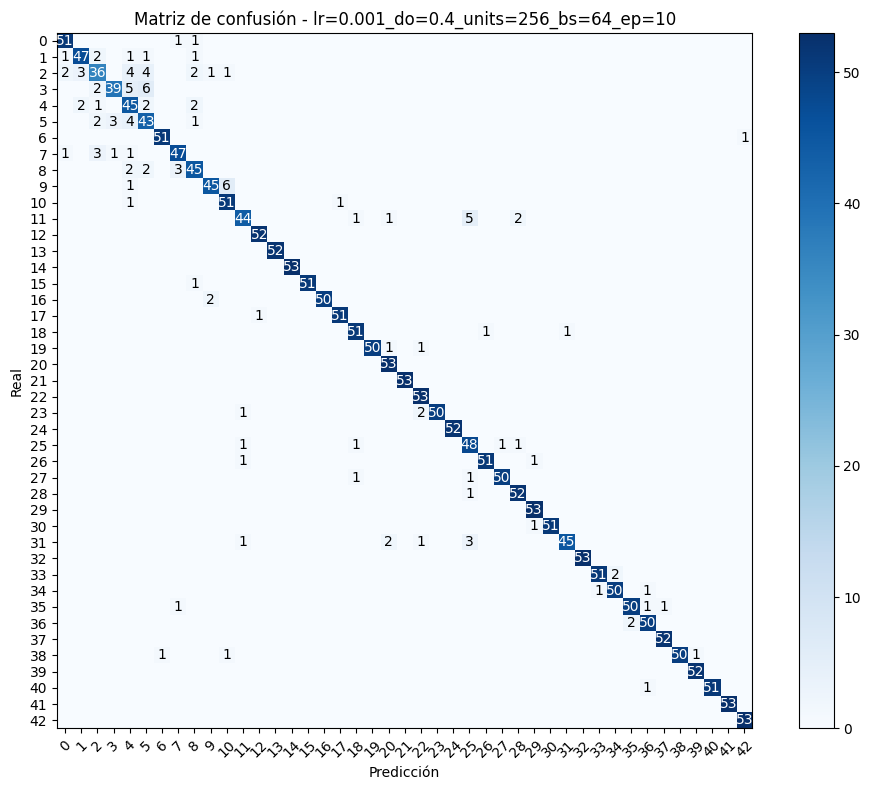

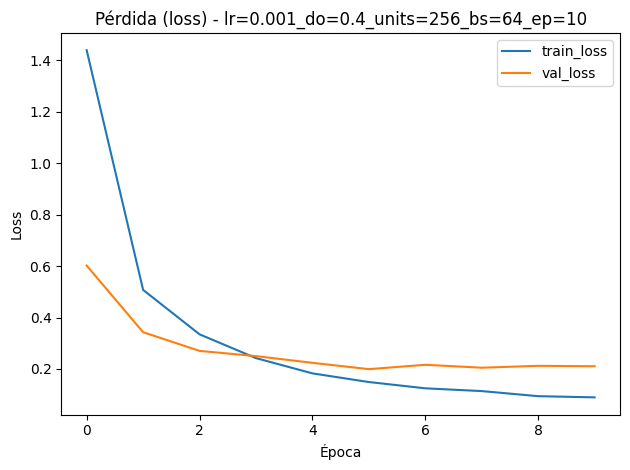

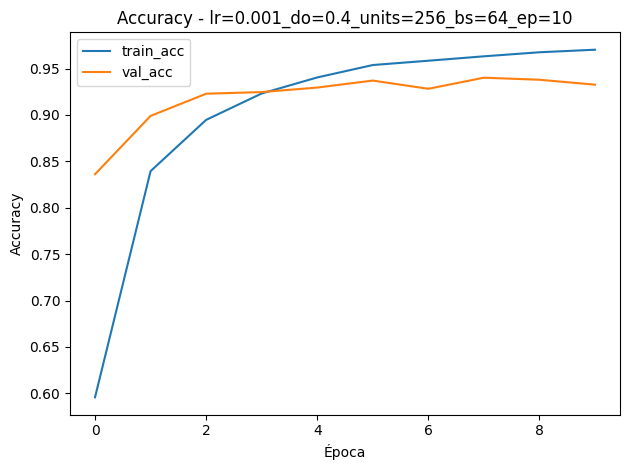

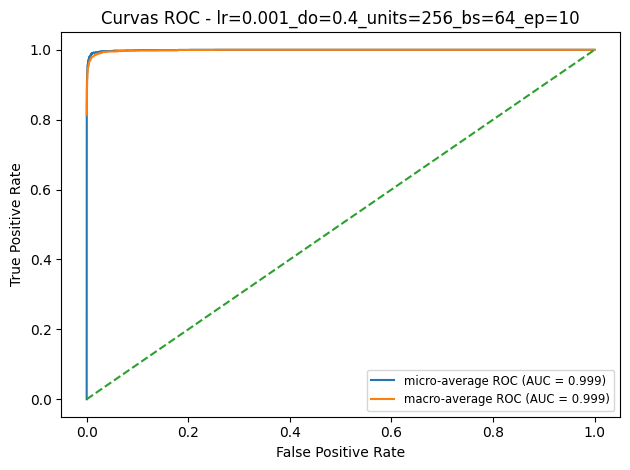

In [11]:
# -------------------------
# Choose the best model
# -------------------------
best_idx = results_df['test_accuracy'].idxmax()
best_config = results_df.loc[best_idx, 'config']
print("\nMejor configuración:", best_config)

best_hist = saved_histories[best_idx]
y_true = saved_true[best_idx]
y_pred, y_prob = saved_preds[best_idx]


# -------------------------
# Confussion matrix
# -------------------------
cm = confusion_matrix(y_true, y_pred)
classes = np.unique(y_true)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f"Matriz de confusión - {best_config}")
plt.colorbar()

# axis labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicción")
plt.ylabel("Real")

# Show values for each cell (only if value is not zero)
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] != 0:
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.show()

# -------------------------
# validation vs training curves
# -------------------------
plt.figure()
plt.plot(best_hist['loss'], label='train_loss')
plt.plot(best_hist['val_loss'], label='val_loss')
plt.title(f'Pérdida (loss) - {best_config}')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(best_hist['accuracy'], label='train_acc')
plt.plot(best_hist['val_accuracy'], label='val_acc')
plt.title(f'Accuracy - {best_config}')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# ROC curves (one-vs-rest)
# -------------------------
# labels binarization
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC (AUC = {roc_auc["micro"]:.3f})')
plt.plot(fpr["macro"], tpr["macro"], label=f'macro-average ROC (AUC = {roc_auc["macro"]:.3f})')
plt.plot([0,1],[0,1],'--')
plt.title(f'Curvas ROC - {best_config}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right", fontsize='small')
plt.tight_layout()
plt.show()


Evaluating KNN with k=1

Evaluating KNN with k=3

Evaluating KNN with k=5

Evaluating KNN with k=7

Evaluating KNN with k=13


,config,k,test_accuracy,precision,recall,f1_score
0,KNN_k=1,1,0.8494,0.8563,0.8496,0.8480
1,KNN_k=3,3,0.7697,0.7917,0.7700,0.7720
2,KNN_k=5,5,0.7414,0.7577,0.7416,0.7397
3,KNN_k=7,7,0.7095,0.7242,0.7097,0.7055
4,KNN_k=13,13,0.6581,0.6734,0.6584,0.6476


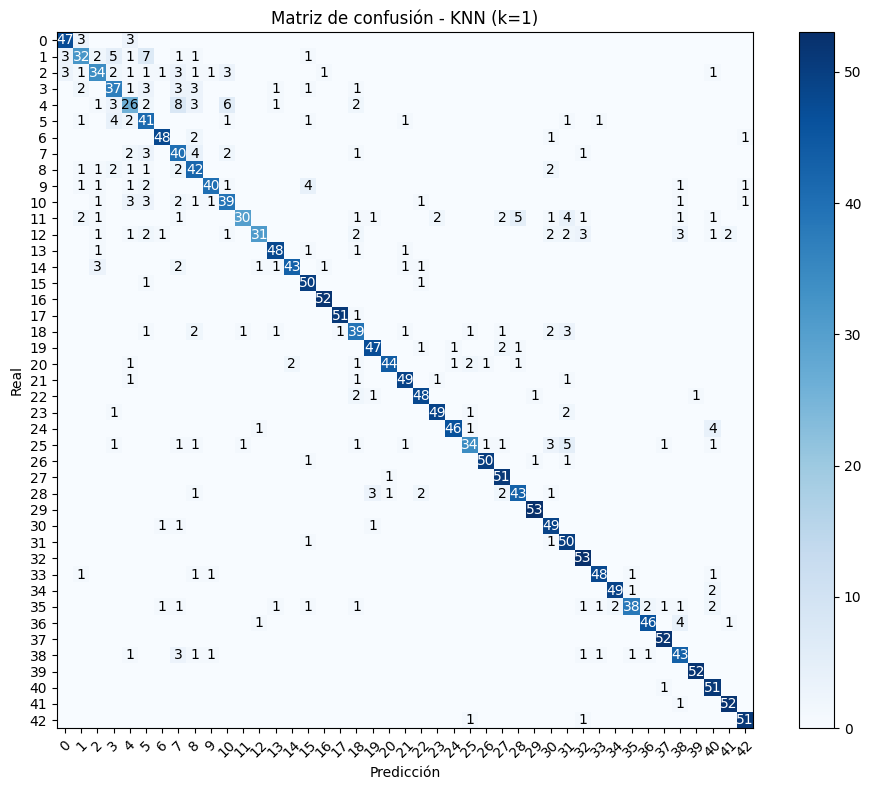

In [12]:


# Aplanado y escalado
X_train = training_data.reshape((training_data.shape[0], -1))
X_val   = val_data.reshape((val_data.shape[0], -1))
X_test  = test_data.reshape((test_data.shape[0], -1))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

y_train = training_labels
y_val   = val_labels
y_test  = test_labels

# Probar distintos valores de k
k_values = [1, 3, 5, 7, 13]
results_knn = []
confusions_knn = {}

for k in k_values:
    print(f"\nEvaluating KNN with k={k}")
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)

    # Clasification report
    report = classification_report(y_test, y_pred, output_dict=True)
    results_knn.append({
        'config': f'KNN_k={k}',
        'k': k,
        'test_accuracy': report['accuracy'],
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1_score': report['macro avg']['f1-score'],
        'y_pred': y_pred
    })

    # Save confusion matrix
    confusions_knn[k] = confusion_matrix(y_test, y_pred)

# -------------------------
# Tabla de resultados con estilo visual
# -------------------------
df_knn = pd.DataFrame(results_knn).drop(columns='y_pred')
df_knn = df_knn.sort_values("test_accuracy", ascending=False).reset_index(drop=True)

cols_metrics = ['test_accuracy', 'precision', 'recall', 'f1_score']
df_knn[cols_metrics] = df_knn[cols_metrics].round(4)

styled_knn_df = df_knn.style.set_caption("Resultados de Configuraciones del Modelo KNN") \
    .background_gradient(subset=cols_metrics, cmap='Blues') \
    .format(precision=4) \
    .set_properties(**{'text-align': 'right'}) \
    .set_table_styles([
        {'selector': 'caption', 'props': [('color', 'black'), ('font-size', '18px'), ('text-align', 'center'), ('font-weight', 'bold')]},
        {'selector': 'th', 'props': [('text-align', 'center')]}
    ])

display(styled_knn_df)

# -------------------------
# Matriz de confusión del mejor modelo
# -------------------------
best_knn_row = df_knn.iloc[0]
best_k = best_knn_row['k']
best_y_pred = [r['y_pred'] for r in results_knn if r['k'] == best_k][0]
cm = confusions_knn[best_k]

classes = np.unique(y_test)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f"Matriz de confusión - KNN (k={int(best_k)})")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicción")
plt.ylabel("Real")

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] != 0:
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


### 4.3. Conclusions & Future Improvements

#### Key Findings
- A transfer‑learning CNN (MobileNetV2 backbone + custom head) delivers **high, class‑balanced performance** on German traffic signs.  
- Errors are mostly between **visually similar classes** (e.g., close speed limits or warning triangles), not random noise—so the model has genuinely learned discriminative features.  
- Compared with a classical baseline (kNN), the CNN is **clearly superior** in accuracy, macro metrics, and confusion‑matrix concentration, confirming the value of convolutional feature extraction.

#### Real‑World Applicability
- **ADAS / Driver Assistance:** The achieved accuracy and ROC behavior suggest the model could serve as a module in an Advanced Driver Assistance System to instantly classify detected signs once a detector (e.g., YOLO) isolates them.  
- **Mobile / Edge deployment:** MobileNetV2 is lightweight, so with quantization or pruning it can run in real time on embedded devices (dashcams, smartphones, Raspberry Pi + accelerator).  
- **Infrastructure monitoring:** Beyond cars, municipalities could use it to audit signage quality in street imagery (detect faded/missing/incorrect signs).  
- **Training simulators & e‑learning:** Immediate feedback on sign recognition for learner drivers.


#### Future Improvements
1. **Fine‑tuning & Better Backbones**  
   - Unfreeze upper layers of MobileNetV2 or try EfficientNet/ConvNeXt to capture finer details.  
   - Add learning‑rate schedules or cosine decay to squeeze a bit more accuracy.

2. **Targeted Data Augmentation**  
   - Apply augmentations that mimic real-world variability (motion blur, glare, partial occlusion).  
   - Oversample or synthesize the confusing classes to increase recall there.

3. **Detection + Classification Pipeline**  
   - Integrate an object detector (YOLOv8, SSD) to first localize signs, then classify with the CNN.  
   - End‑to‑end training could further reduce false positives.

4. **Continuous Learning / Domain Adaptation**  
   - Use active or semi‑supervised learning to incorporate new sign styles/countries.  
   - Periodically retrain with fresh camera feeds to handle changing conditions.

5. **Explainability & Monitoring**  
   - Employ Grad‑CAM to highlight which pixels drive each decision; useful for debugging and for regulatory approval.  
   - Implement drift detection to monitor performance once deployed.

**Overall conclusion:** The CNN is production‑ready as a **classification core**, provided it is embedded in a full perception stack and accompanied by the engineering steps above (detection, calibration, deployment optimization, and continuous monitoring). The work demonstrates that modern transfer‑learning architectures can reliably understand traffic signage with modest computational budgets, but real‑world integration still demands careful attention to data shifts, latency, and robustness.
